In [39]:
%%capture
!pip install pyglet==1.5.1
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [40]:
%%capture
!pip install gym==0.24
!pip install pygame
!pip install numpy

!pip install imageio imageio_ffmpeg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

We are going to create a non-slippery 4x4 environment using the Frozen Lake gym library.

There are two grid versions, “4x4” and “8x8”.
If the `is_slippery=True`, the agent may not move in the intended direction due to the slippery nature of the frozen lake.
After initializing the environment, we will do an environmental analysis.

In [42]:
env = gym.make("FrozenLake-v1",map_name="8x8",is_slippery=True)

print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # display a random observation

Observation Space Discrete(64)
Sample observation 12


Let’s discover the number of actions and display the random action.

The action space:

0. move left
1. move down
2. move right
3. move up

Reward function:

- Reaching the goal: +1
- Falling into the hole: 0
- Staying on the frozen lake: 0

In [43]:
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

Action Space Shape 4
Action Space Sample 3


In [44]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  64  possible states
There are  4  possible actions


## Create and Initialize the Q-table
The Q-Table has columns as actions, and rows as states. We can use OpenAI Gym to find action space and state space. We will then use this information to create the Q-Table.

In [45]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)

\

In [46]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

As we now know that Q-learning is an off-policy algorithm which means that the policy of taking action and updating function is different.

In this example, the Epsilon Greedy policy is acting policy, and the Greedy policy is updating policy.

The Greedy policy will also be the final policy when the agent is trained. It is used to select the highest state and action value from the Q-Table.

In [47]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])
  return action

These hyperparameters are used in the training loop, and fine-tuning them will give you better results.

- The Agent needs to explore enough state space to learn good value approximation; we need to have progressive decay of epsilon. If the decay rate is high, the agent might get stuck as it has not explored enough state space.

- There are 10,000 training and 100 evaluation episodes.
- The learning rate is 0.7.
- We are using "FrozenLake-v1" as an environment with 99 maximum steps per episode.
- The gamma (discount rate) is 0.95.
- eval_seed: evaluation seed for the environment.
- The exploration epsilon probability at the start is 1.0, and the minimum probability will be 0.05.
- The exponential decay rate for epsilon probability is 0.0005.

In [59]:
# Training parameters
n_training_episodes = 50000
learning_rate = 0.5

# Evaluation parameters
n_eval_episodes = 200

# Environment parameters
env_id = "FrozenLake-v1"
max_steps = 200

#how the agent values future rewards as compared to immediate rewards
gamma = 0.95
eval_seed = []

# Exploration parameters
# epsilon will determinate if use the best known action, or one aleatory to explore
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.000005

In the training loop, we will:

1. Create a loop for training episodes.
2. We will first reduce epsilon. As we need less and less exploration and more exploitation with every episode.
3. Reset the environment.
4. Create a nested loop for the maximum steps.
5. Choose the action using the epsilon greedy policy.
6. Take action (At) and observe the expected reward(Rt+1) and state(St+1).
7. Take the action (a) and observe the outcome state(s') and reward (r).
8. Update the Q-function using the formula.
9. If `done= True`, finish the episode and break the loop.
10. Finally, change the current state to a new state.
11. After completing all of the training episodes, the function will return the updated Q-Table.

In [60]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):

    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):

      action = epsilon_greedy_policy(Qtable, state, epsilon)


      new_state, reward, done, info = env.step(action)


      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If done, finish the episode
      if done:
        break

      # Our state is the new state
      state = new_state
  return Qtable

In [61]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [62]:
Qtable_frozenlake

array([[1.78642246e-01, 1.91647254e-01, 1.81831115e-01, 2.00639925e-01],
       [1.85917320e-01, 1.89959086e-01, 2.00855931e-01, 2.16109934e-01],
       [2.10805566e-01, 2.28407145e-01, 2.33905343e-01, 2.50053763e-01],
       [2.30384444e-01, 2.47573075e-01, 2.46506676e-01, 2.77344975e-01],
       [2.91940318e-01, 2.84718003e-01, 3.07233848e-01, 2.98124227e-01],
       [3.13672541e-01, 3.10459908e-01, 3.33683267e-01, 3.17600161e-01],
       [3.36672141e-01, 3.50945844e-01, 3.47153800e-01, 3.40863626e-01],
       [3.55060341e-01, 3.55264804e-01, 3.59641501e-01, 3.38335462e-01],
       [1.74743645e-01, 1.65886520e-01, 1.69515764e-01, 1.75286643e-01],
       [1.83658795e-01, 1.71897269e-01, 1.70705095e-01, 1.79775415e-01],
       [1.82232809e-01, 2.00233933e-01, 2.24270662e-01, 2.09396350e-01],
       [2.28472389e-01, 2.24468578e-01, 1.90257655e-01, 2.22595193e-01],
       [2.88239801e-01, 2.47836180e-01, 2.77709136e-01, 3.13975233e-01],
       [3.11689433e-01, 2.85249327e-01, 3.21937218e

## Evaluation
---
The evaluate_agent runs for `n_eval_episodes` episodes and returns the mean and standard deviation of the reward.

1. In the loop, we will first check if there is an evaluation seed. If not, then we will reset the environment without seed.
2. The nested loop will run to max_steps.
3. The agent will take the action that has the maximum expected future reward in a given state using Q-Table.
4. Calculate the reward.
5. Change the state.
5. If done (agent falls into the hole or goal has been achieved), break the loop.
6. Append the results.

8. In the end, we will use these results to calculate the mean and standard deviation.

In [63]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):

  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum reward
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [64]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=0.21 +/- 0.41


In [65]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []
  done = False
  state = env.reset(seed=random.randint(600,800))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

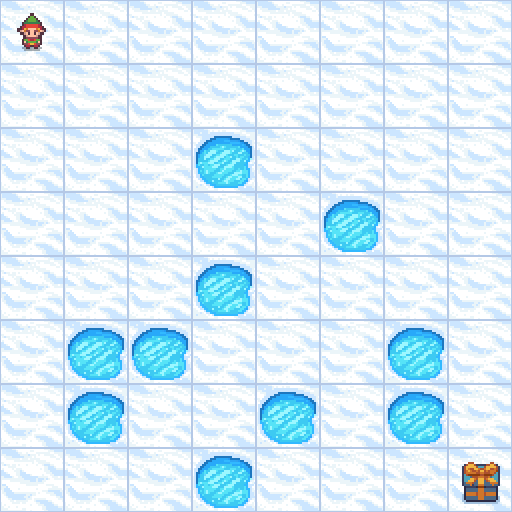

In [66]:
video_path="/content/replay.gif"
video_fps=3
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')